# Notes

## Learning
- Check Ressources OC à utiliser au début : https://openclassrooms.com/fr/paths/795/projects/1517/resources

- Helping ressources :
    - `Cours CS231n`
        - `CNN : https://cs231n.github.io/convolutional-networks/`
        - `Understanding & visualizing CNN : https://cs231n.github.io/understanding-cnn/`
        - `Transfer Learning : https://cs231n.github.io/transfer-learning/`
    - Arithmetics :
        - Guide to Convolution arithmetics -31 p- : https://arxiv.org/pdf/1603.07285.pdf
    - Image Segmentation with pretrained model with HuggingFace & Tensorflow
        - https://www.geeksforgeeks.org/image-segmentation-using-tensorflow/
        - tensorflow : https://www.tensorflow.org/tutorials/images/segmentation
        - https://huggingface.co/docs/transformers/tasks/semantic_segmentation
        - SOTA models huggingface : https://huggingface.co/blog/mask2former
        - Fine-tuning segformer : https://huggingface.co/blog/fine-tune-segformer
    - UNET : https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
    - Albumentations : https://albumentations.ai/docs/examples/example/


## Workflow
https://docs.google.com/document/d/1kIbxaqzdPZqHEJRxwuFCAar-G8W78VFRgDUEF5Mesjw/edit?invite=CI_q4swC&tab=t.0


## To-Do

- Analyse pré-exploratoire et préparation des données
    - Regarder l'équilibre des catégories avant le train-test-split ? Possible avec np.unique_counts(img_array) sur chaque image (se servir du multiprocessing)
    - Crée le train test split avec shuffle et 0.2

- Datagenerator (tf.keras.utils.PyDataset) : https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    - Ajouter la partie data augmentation (rotation, flip, zoom, etc.)
    - Appliquer le data loader ensuite sur train - val - test

- Mlflow integration
    - Tester l'intégration de mlflow avec le modèle et le datagenarator

- Modele
    - Ajouter les callbacks (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
    - Ajouter les métriques IoU et Dice
    - Ajouter les métriques IoU et Dice dans le modèle
    - Ajouter les métriques IoU et Dice dans le callback
    - fonction de visualisation sur la prédiction



# Future comms

##  **Les différents types de segmentation**
---

Un modèle de segmentation d'image génère en sortie une carte de segmentation où chaque pixel est classifié dans une catégorie spécifique. La structure de la couche de sortie dépend du type de segmentation :


### **1. Segmentation sémantique (ex : UNet, DeepLabV3)**
Chaque pixel appartient à une classe parmi un nombre fixe de classes.

- **Couche de sortie** : une convolution 2D avec autant de canaux que de classes (`Conv2D(num_classes, kernel_size=1)`).  
- **Tenseur de sortie** : `[batch_size, height, width, num_classes]`.  
- **Post-traitement** : on applique une fonction **softmax** (multiclasses) ou **sigmoïde** (binaire) pour obtenir des probabilités.  
- **Prédiction finale** : l'index du canal ayant la probabilité la plus élevée pour chaque pixel.  

💡 **Exemple en segmentation binaire (ex : fond vs objet)**  
- Dernière couche : `Conv2D(1, kernel_size=1, activation="sigmoid")`  
- La sortie est de forme `[batch_size, height, width, 1]` avec des valeurs entre 0 et 1 (probabilité d'appartenir à la classe positive).

💡 **Exemple en segmentation multiclasse (ex : route, voiture, ciel, etc.)**  
- Dernière couche : `Conv2D(num_classes, kernel_size=1, activation="softmax")`  
- La sortie est `[batch_size, height, width, num_classes]`, et on prend `argmax` sur l'axe des classes.


### **2. Segmentation instance (ex : Mask R-CNN)**
Chaque instance d'un objet a un identifiant unique.

- **Sortie plus complexe** :  
  - Une **carte de segmentation** par objet détecté (`[batch_size, num_objects, height, width]`).  
  - Une **carte des scores** (`[batch_size, num_objects]`) pour indiquer la confiance de chaque masque.  
  - Une **boîte englobante** pour chaque instance.  

Ici, chaque pixel peut appartenir à plusieurs objets en même temps, contrairement à la segmentation sémantique.


### **Résumé**
| Type de segmentation | Forme de sortie | Activation | Post-traitement |
|----------------------|----------------|------------|-----------------|
| **Binaire** | `[batch, h, w, 1]` | Sigmoïde | Seuil (0.5) |
| **Multiclasse** | `[batch, h, w, num_classes]` | Softmax | `argmax` sur classes |
| **Instance** | `[batch, num_objects, h, w]` + scores | Variable | Seuil + NMS |

## **Présentation de UNET**

---

**UNet**, un modèle bien connu pour la segmentation sémantique. Ce modèle prend une image RGB de **256x512x3** et renvoie une carte de segmentation de **256x512x8** avec 8 classes.  

### **Architecture du modèle :**
- Encodeur (feature extractor) basé sur **convolutions** + **max pooling** pour extraire les features.
- Décodeur avec **upsampling** pour revenir à la résolution d'origine.
- Dernière couche avec **8 canaux** et activation **softmax** pour obtenir une distribution de probabilité sur les classes.



### **Explication de la sortie :**
- La dernière couche `Conv2D(8, (1,1), activation="softmax")` génère un tenseur **(256, 512, 8)**.
- Chaque pixel contient un vecteur de **8 probabilités** (une par classe).
- Pour obtenir l’image segmentée finale, on prend `argmax` sur l’axe des classes pour assigner chaque pixel à la classe la plus probable.


### **Résumé :**
✅ **Entrée** : Image `(256,512,3)`  
✅ **Sortie** : Carte de segmentation `(256,512,8)`  
✅ **Activation finale** : `softmax` pour classification pixel par pixel  
✅ **Post-traitement** : `argmax` pour obtenir la classe de chaque pixel  

## **Format des labels de sortie pour la segmentation**

---

Le format des labels dépend de la **fonction de perte** utilisée. Comme ta couche de sortie utilise une activation **softmax** et génère une sortie `(num_batches, 256, 512, 8)`, voici les deux options possibles :  


### **1️⃣ Labels sous forme d’index : `(num_batches, 256, 512)`**  
👉 **Format :** Chaque pixel est représenté par un entier correspondant à l'index de sa classe (0 à 7).  
👉 **Fonction de perte :** `SparseCategoricalCrossentropy(from_logits=False)`  

**Exemple d'un batch de labels :**  
```python
y_true.shape  # (num_batches, 256, 512), dtype=int
y_true[0, 100, 200]  # Exemple : 3 (classe 3 assignée au pixel (100,200))
```

✅ **Avantages** :
- Plus léger en mémoire.  
- Pas besoin de conversion avant l’entraînement.  

🚀 **Comment charger les labels ?**  
```python
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
```


### **2️⃣ Labels en one-hot : `(num_batches, 256, 512, 8)`**  
👉 **Format :** Chaque pixel est représenté par un vecteur de probabilité où une seule position est à 1 (one-hot encoding).  
👉 **Fonction de perte :** `CategoricalCrossentropy(from_logits=False)`  

**Exemple d'un pixel encodé en one-hot (classe 3)** :  
```python
[0, 0, 0, 1, 0, 0, 0, 0]  # Classe 3 activée
```

✅ **Avantages** :
- Permet de travailler avec des **poids de classes** si les classes sont déséquilibrées.  
- Peut être plus stable pour certaines architectures.  

🚀 **Comment charger les labels ?**  
```python
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
```
💡 Si tes labels sont sous forme `(num_batches, 256, 512)`, il faut les **convertir en one-hot** avant l’entraînement :  
```python
y_true_onehot = tf.one_hot(y_true, depth=8)  # Convertit (batch, 256, 512) → (batch, 256, 512, 8)
```



### **📌 Quelle approche choisir ?**  
✅ **Si tes labels sont stockés comme une image avec une seule valeur par pixel** → **`SparseCategoricalCrossentropy`** (option 1, plus simple).  
✅ **Si tu veux manipuler les probabilités ou ajuster les poids des classes** → **`CategoricalCrossentropy`** (option 2, one-hot).  

🚀 **Recommandation :** Utilise la première approche `(num_batches, 256, 512)` car elle est plus efficace en mémoire et plus simple à gérer.  


## **ConvNet Architectures**
We have seen that Convolutional Networks are commonly made up of only three layer types: CONV, POOL (we assume Max pool unless stated otherwise) and FC (short for fully-connected). We will also explicitly write the RELU activation function as a layer, which applies elementwise non-linearity. In this section we discuss how these are commonly stacked together to form entire ConvNets.

- Converting FC layers to CONV layers
    - It is worth noting that the only difference between FC and CONV layers is that the neurons in the CONV layer are connected only to a local region in the input, and that many of the neurons in a CONV volume share parameters. However, the neurons in both layers still compute dot products, so their functional form is identical. Therefore, it turns out that it’s possible to convert between FC and CONV layers:


### 📌 **1. Composants d'un CNN**
Un CNN est constitué de plusieurs types de couches :

#### **🔹 Couches Convolutives (Conv Layer)**
- Appliquent des filtres (kernels) pour extraire des **caractéristiques locales**.
- Génèrent des **cartes de caractéristiques (feature maps)**.
- Hyperparamètres : **taille du kernel, stride, padding**.

#### **🔹 Couches d'Activation**
- Introduisent la **non-linéarité**.
- Fonction la plus courante : **ReLU** (Rectified Linear Unit).

#### **🔹 Couches de Pooling (Sous-échantillonnage)**
- Réduisent la **dimensionnalité** et la **sensibilité au bruit**.
- Types :
  - **Max Pooling** : prend la valeur maximale d’une région.
  - **Average Pooling** : prend la moyenne.

#### **🔹 Couches Fully Connected (Dense)**
- Transforme les cartes de caractéristiques en un **vecteur** pour la classification.
- Dernière couche : souvent **Softmax** pour la classification multi-classes.

---

### 🔥 **2. Architectures Populaires de CNN**
Voici quelques architectures CNN célèbres :

#### **1️⃣ LeNet-5 (1998)**
- Premier CNN utilisé pour la reconnaissance de chiffres manuscrits.
- **Structure** :
  - Conv → Pool → Conv → Pool → Dense → Output
- Très simple mais efficace pour de petites images (comme MNIST).

#### **2️⃣ AlexNet (2012)**
- A révolutionné la vision par ordinateur en gagnant ImageNet.
- **Structure** :
  - 5 Convolution + Pooling → 3 Fully Connected
- Introduit **ReLU**, **Dropout** et **GPU training**.

#### **3️⃣ VGG (2014)**
- Approche modulaire avec des **kernels 3x3** pour toutes les convolutions.
- **Variantes : VGG-16, VGG-19**.
- Très profond mais lourd en calcul.

#### **4️⃣ GoogLeNet (Inception) (2014)**
- Introduit les **Inception Blocks** : différentes tailles de filtres en parallèle.
- **Moins de paramètres** qu’AlexNet ou VGG grâce à l’utilisation de convolutions 1x1.

#### **5️⃣ ResNet (2015)**
- Introduit les **skip connections (résiduals)**.
- Résout le problème du **gradient vanishing** dans les réseaux profonds.
- Variantes : **ResNet-18, ResNet-34, ResNet-50, ResNet-101**.

#### **6️⃣ EfficientNet (2019)**
- Basé sur une optimisation du **scaling** (taille des filtres, profondeur, résolution).
- Très performant avec moins de calculs que ResNet.

---

### 🚀 **3. Conception d’un CNN en TensorFlow/Keras**
Un exemple de CNN simple avec **Keras** :

```python
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes pour classification
])

model.summary()
```

---

### 🎯 **4. Choisir une Architecture CNN**
| **Modèle**   | **Avantages** | **Inconvénients** |
|-------------|--------------|----------------|
| **LeNet-5**  | Simple et rapide | Mauvaise généralisation sur images complexes |
| **AlexNet**  | Performant sur grands datasets | Très lourd en calcul |
| **VGG**      | Facile à implémenter | Nombre de paramètres énorme |
| **GoogLeNet** | Moins de paramètres | Complexe à implémenter |
| **ResNet**   | Permet des réseaux très profonds | Plus gourmand en mémoire |
| **EfficientNet** | Performant et léger | Architecture optimisée difficile à ajuster |


## Conversion des couches FC et CONV

---

### 🔹 **1. Passage de l'extraction de caractéristiques à la classification**
- **Les couches convolutives** apprennent des **descripteurs locaux** (bords, textures, motifs).
- **Les couches fully connected** interprètent ces descripteurs pour faire une **prédiction globale**.
- Convertir une couche conv en dense permet de **transformer les cartes de caractéristiques en un vecteur de décision**.


### 🔹 **2. Compatibilité avec un classifieur classique**
- **Les couches convolutives génèrent des matrices 3D** (hauteur, largeur, canaux).
- **Les couches fully connected prennent des vecteurs en entrée**.
- La conversion (via un `Flatten()`) permet d'utiliser un **classifieur dense** comme Softmax ou une MLP.

🔹 **Exemple en TensorFlow/Keras** :
```python
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),  # Conversion de la sortie convolutive en vecteur
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # Classification sur 10 classes
])
```
- La couche `Flatten()` convertit la sortie des convolutions en **un vecteur 1D** utilisable par les couches `Dense`.

---

### 🔹 **3. Réduction de la dimensionnalité et adaptation aux tâches**
- Dans certains cas, une conversion en fully connected permet de **réduire la taille des paramètres** et d'ajuster l'architecture.
- Exemple : en **transformant les cartes de caractéristiques en un vecteur plus petit**, on peut mieux généraliser et éviter le surajustement.

---

### 🔹 **4. Simulation d’une convolution avec une couche Dense**
- Une **couche convolutionnelle peut être réécrite comme une couche dense** si l'on ignore le partage de poids.
- Exemple : une **convolution 1x1 avec autant de filtres que d'entrées** est **équivalente à une couche dense**.

---

### 🔹 **5. Réduction du besoin en mémoire et calcul**
- **Transformer une convolution en fully connected** peut parfois réduire la mémoire et accélérer l’inférence.
- Exemple : Dans certains modèles mobiles (**MobileNet, SqueezeNet**), une **dernière convolution 1x1 remplace les couches fully connected** pour réduire le nombre de paramètres.

---

### 🎯 **Conclusion**
✅ **Transformer une couche convolutive en fully connected** permet :
- D’adapter les sorties convolutives pour une tâche de classification.
- D’obtenir un vecteur compatible avec des classifieurs denses.
- De modifier l’architecture pour réduire la complexité.

👉 **Alternatives modernes** : Au lieu de `Flatten()`, certains modèles utilisent **Global Average Pooling (GAP)** pour obtenir une sortie plus robuste et compacte :

```python
layers.GlobalAveragePooling2D()
```

## Pooling vs Convolution avec Stride

---

### 🔹 **1. Différences entre Pooling et Convolution avec Stride**
| **Critère** | **Pooling (Max/Average)** | **Convolution avec Stride** |
|------------|--------------------------|----------------------------|
| **Principe** | Sous-échantillonne l’image en prenant un maximum (max pooling) ou une moyenne (average pooling). | Utilise des filtres qui glissent sur l’image avec un pas (`stride > 1`), supprimant ainsi des pixels. |
| **Perte d’information** | Peut perdre des détails importants (surtout avec max pooling). | Garde plus d’informations car la convolution apprend des poids adaptés. |
| **Paramètres appris** | Aucun (opération fixe). | Oui (les poids du filtre sont optimisés pendant l’entraînement). |
| **Consommation mémoire** | Moins coûteux (aucun paramètre à apprendre). | Plus gourmand en calculs (paramètres à optimiser). |
| **Effet sur le gradient** | Peut causer des pertes d’informations abruptes et un gradient moins stable. | Lisse mieux la propagation du gradient grâce aux poids appris. |

---

### 🔥 **2. Pourquoi utiliser une convolution avec stride à la place du pooling ?**
#### ✅ **Avantages de la convolution avec stride :**
1. **Meilleure optimisation** :  
   - Les **poids du filtre** sont appris, contrairement au pooling qui est une opération fixe.
   - Permet au modèle d’optimiser l’extraction de caractéristiques sans perdre trop d’informations.
   
2. **Propagation du gradient améliorée** :  
   - Moins de perte d’information abrupte que le max pooling.
   - Réduit le risque de disparition du gradient dans les réseaux très profonds.

3. **Moins d’opérations distinctes** :  
   - Évite d’avoir une couche supplémentaire pour le pooling → simplifie l’architecture.

4. **Utilisé dans les architectures modernes** :  
   - **ResNet, MobileNet, DenseNet** préfèrent **les convolutions avec stride** au lieu des **poolings classiques**.

---

### ⚠️ **3. Mais faut-il complètement éviter le pooling ?**
Pas forcément ! Il existe des cas où le **pooling reste utile** :

1. **Max pooling pour une meilleure invariance aux translations**  
   - Le max pooling **réduit la sensibilité aux petits déplacements** dans l’image.
   - Utile pour **des tâches de reconnaissance d’objets** où la position exacte n’est pas importante.

2. **Average pooling dans les architectures récentes**  
   - Le **Global Average Pooling (GAP)** est souvent utilisé pour réduire les dimensions tout en gardant une bonne généralisation :
   ```python
   layers.GlobalAveragePooling2D()
   ```
   - Utilisé dans **ResNet, MobileNet** pour éviter des couches fully connected trop grandes.

---

### 🎯 **4. Recommandation selon les cas**
| **Cas d’usage** | **Pooling classique** | **Convolution avec stride** |
|----------------|----------------------|----------------------------|
| **Tâches classiques (classification d’images)** | ✅ Max Pooling souvent efficace. | 🚫 Pas toujours nécessaire. |
| **Modèles modernes (MobileNet, ResNet, EfficientNet)** | 🚫 Souvent remplacé par GAP. | ✅ Strided Convolution préférable. |
| **Besoin d’invariance aux translations** | ✅ Max Pooling utile. | 🚫 Moins efficace. |
| **Optimisation des calculs sur GPU** | 🚫 Pooling moins flexible. | ✅ Strided Convolution plus efficace sur certains hardware. |

---

### 🎯 **Conclusion**
👉 **Remplacer le pooling par une convolution avec stride est souvent bénéfique**, mais pas toujours obligatoire.  
👉 Les architectures modernes tendent à privilégier **les convolutions avec stride ou le Global Average Pooling (GAP)** au lieu du max pooling.  
👉 **Si tu veux un réseau plus optimisé et entraînable, évite le pooling et favorise les convolutions avec stride.** 🚀  

Tu travailles sur quel type de CNN ? 😊

## CONV LAYER & POOL LAYER Input to Output

### CONV LAYER FILTERS (K) AND STRIDE (S) AND PADDING (P) AND SPATIAL EXTENT (F) vs W x H x D (input) 
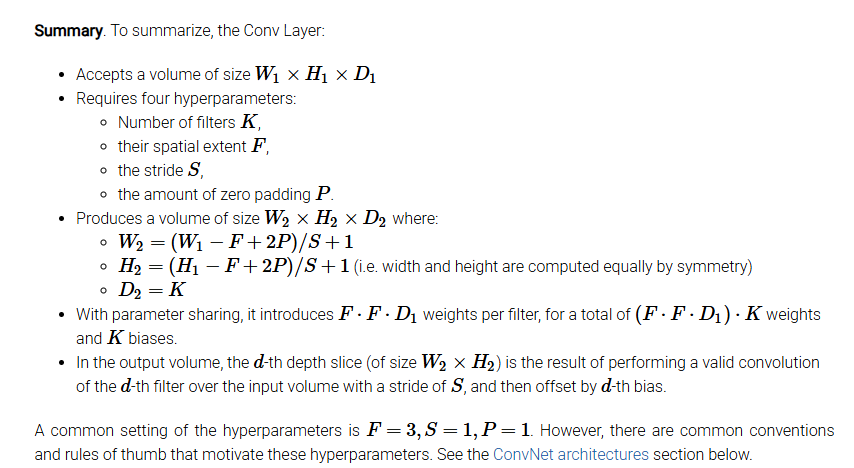

### POOL LAYER FILTERS (K) AND STRIDE (S) AND SPATIAL EXTENT (F) vs W x H x D (input)
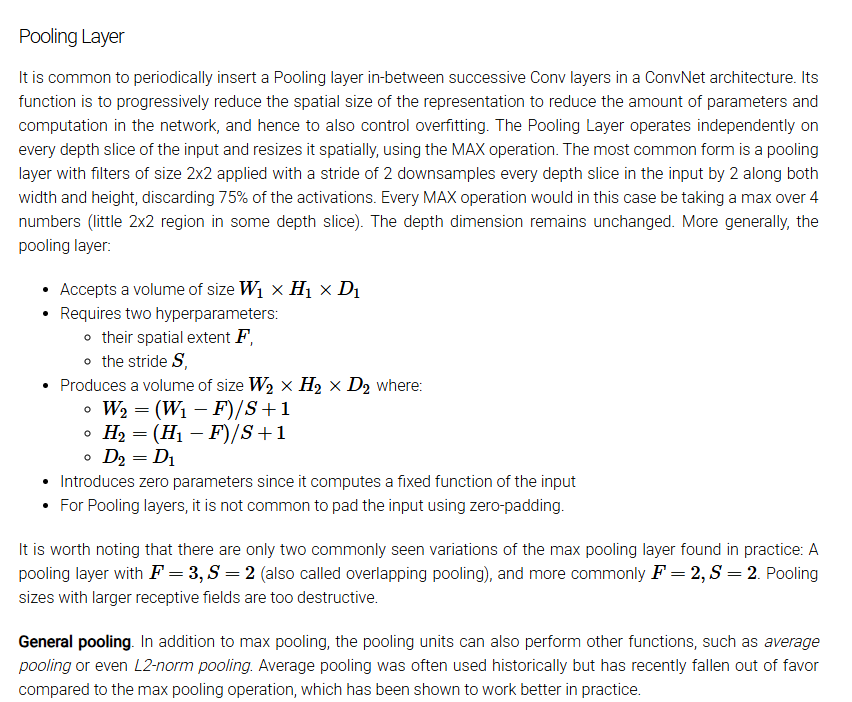

# Code

In [98]:
import pathlib
import os
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import logging
import seaborn as sns
import multiprocessing
from utils_and_constants import labels
import typing
import albumentations as A

np.random.seed(314)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
logging.basicConfig(level=logging.ERROR)

# Présentation des données 

**====================  Dossier `Raw`  ====================**


Le jeu de données utilisé pour la conception du modèle de segmentation d'images est composé de deux répertoires:
- Un répertoire `gtFine` contenant les images de masques annotées (20 000 fichiers). Chaque image se distingue par 4 fichiers différents:
    - Un fichier `color` en couleurs (5 000 fichiers png)
    - Un fichier `instanceIds` en niveaux de gris (5 000 fichiers png)
    - Un fichier `labelIds` en niveaux de gris (5 000 fichiers png)
    - Un fichier `polygons` contenant les coordonnées des zones segmentéees (5 000 fichiers json)
- Un répertoire `leftImg8bit` contenant les images brutes en couleurs (5 000 fichiers)


Chacun de ces répertoires est ensuite subdivisé en trois sous répertoires, qui eux mêmes contiennent des sous-répertoires en fonction des villes:
- `train` contenant les données d'entraînement (2975 images)
- `val` contenant les données de validation  (500 images)
- `test` dont les annotations ne sont pas rendues publiques, donc inexploitables dans le cas présent (1525 images)


Pour plus d'informations sur le dataset, merci de lire le README suivant : https://github.com/mcordts/cityscapesScripts/blob/master/README.md

**====================  Dossier `Sorted`  ====================**


La première étape consiste à préparer les dossiers pour le jeu d'entraînement, de validation et de test dans ce nouveau dossier.<br>
Premièrement, on ignore les dossiers de test puisque nous n'avons pas accès aux annotations.<br>


Après ces étapes de préparation, le dossier `Sorted` contiendra les données suivantes:
- Un répertoire `train` contenant uniquement les fichiers d'images et de masques d'entraînement en niveaux de gris `labelIds` et en couleur `color` soit un total de 2975 * 3 = 8925 fichiers
- Un répertoire `test` contenant uniquement les fichiers d'images et de masques de validation du dossier `val` en niveaux de gris `labelIds` et en couleur `color` soit un total de 500 * 3 = 1500 fichiers


Commençons par vérifier que nous avons bien toutes les données après avoir exécutées les commandes bash dans le terminal:

In [51]:
TARGET_SIZE = (256, 512)
print("New Target Shape: ", TARGET_SIZE)
print("Number of CPU cores available: ", NUM_WORKERS := os.cpu_count())


New Target Shape:  (256, 512)
Number of CPU cores available:  16


In [101]:
class Dataloaderv8(tf.keras.utils.PyDataset):
    def __init__(
        self,
        image_folder: pathlib.Path,
        labels: typing.NamedTuple,
        batch_size: int,
        target_size: typing.Tuple[int, int],
        preview: int = None,  # Load only a subset of the dataset for preview.
        rgb_norm: bool = True,
        shuffle: bool = True,
        label_onehot: bool = False,
        threadpool: bool = False,
        **kwargs,
    ):
        """
        Initialize the Dataloaderv8 data generator.
        """
        super().__init__(**kwargs)

        # Logger initialization
        self.logger = self._setup_logger()

        # Set class attributes initialized with constructor arguments
        self.image_folder = image_folder
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.rgb_norm = rgb_norm
        self.shuffle = shuffle
        self.label_onehot = label_onehot
        self.threadpool = threadpool  # If True, use multiprocessing.Pool

        # Get image and mask file paths using pathlib
        self.image_paths, self.mask_paths = self._load_paths(preview)
        self._validate_paths()

        # Attributes initialized from labels elements
        self.table_id2category = {label.id: label.categoryId for label in self.labels}
        self.num_classes = len(set(self.table_id2category.values()))
        # Disable PIL logging DEBUG
        logging.getLogger("PIL").setLevel(logging.WARNING)

        # Shuffle the dataset before starting
        if self.shuffle:
            self.on_epoch_end()

    # Initialize logger
    def _setup_logger(self):
        logger = logging.getLogger("dataloader")
        logger.setLevel(logging.DEBUG)
        return logger

    # Load image and mask paths and apply preview if requested to slice the dataset
    def _load_paths(self, preview: int):
        # Get image and mask file paths using pathlib
        image_paths = sorted(list(self.image_folder.glob("*leftImg8bit.png")))
        mask_paths = sorted(list(self.image_folder.glob("*labelIds.png")))

        # Apply preview if requested
        if preview is not None:
            image_paths = image_paths[:preview]
            mask_paths = mask_paths[:preview]

        return image_paths, mask_paths

    # Validate that the number of images and masks are equal before starting
    def _validate_paths(self):
        if len(self.image_paths) != len(self.mask_paths):
            self.logger.error(
                "Number of images (%d) and masks (%d) must be equal.",
                len(self.image_paths),
                len(self.mask_paths),
            )
            raise ValueError("Number of images and masks must be equal.")

    # Return the number of samples in the dataset using dynamic property
    @property
    def num_samples(self):
        return len(self.image_paths)

    # Class method to return the number of batches in the dataset using len()
    def __len__(self) -> int:
        length = math.ceil(self.num_samples / self.batch_size)
        self.logger.debug(f"Number of batches: {length}")
        return length

    # Class method to fetch a batch of images and masks with the given index
    def __getitem__(self, index: int):
        # Calculate start and end indices for the batch
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)
        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")
        # Fetch batch image and mask paths using start and end indices
        batch_images_paths = self.image_paths[start_idx:end_idx]
        batch_masks_paths = self.mask_paths[start_idx:end_idx]
        # Log the batch fetching
        self.logger.debug(
            f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}"
        )
        # Load images and masks using multiprocessing if threadpool is True
        if self.threadpool:
            self.use_multiprocessing = False
            with multiprocessing.Pool() as pool:
                batch_images = pool.map(self.load_img_to_array, batch_images_paths)
                batch_masks = pool.map(self.load_mask_to_array, batch_masks_paths)
                # Transform masks to categorical if label_onehot is True
                if self.label_onehot:
                    batch_masks = pool.map(
                        self.transform_mask_to_categorical, batch_masks
                    )
        # Load images and masks using list comprehension if threadpool is False
        else:
            batch_images = [self.load_img_to_array(path) for path in batch_images_paths]
            batch_masks = [self.load_mask_to_array(path) for path in batch_masks_paths]
            # Transform masks to categorical if label_onehot is True
            if self.label_onehot:
                batch_masks = [
                    self.transform_mask_to_categorical(mask) for mask in batch_masks
                ]
        # Return batch images and masks as numpy arrays
        return np.asarray(batch_images), np.asarray(batch_masks)

    # Shuffle the dataset before starting a new epoch
    def on_epoch_end(self):
        if self.shuffle:
            zip_paths = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(zip_paths)
            self.image_paths, self.mask_paths = zip(*zip_paths)
        else:
            pass

    # Normalize the image array if rgb_norm is True
    def _normalize_img(self, img_array):
        return img_array / 255.0

    # Load image to array and normalize if rgb_norm is True
    def load_img_to_array(self, img_path: pathlib.Path, display_only=False):
        img = tf.keras.utils.load_img(
            str(img_path),
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        if display_only:
            return img
        img_array = tf.keras.utils.img_to_array(img, dtype=np.float32)
        return self._normalize_img(img_array) if self.rgb_norm else img_array

    # Load mask to array and map mask ids to categories
    def load_mask_to_array(self, mask_path: pathlib.Path):
        mask = tf.keras.utils.load_img(
            str(mask_path),
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        mask_array = tf.keras.utils.img_to_array(mask, dtype=np.int8)
        # Map mask ids to categories
        mapped = np.vectorize(self.table_id2category.get)(mask_array)
        return mapped.squeeze()

    # Transform mask to categorical one-hot encoding
    def transform_mask_to_categorical(self, mask):
        return tf.keras.utils.to_categorical(mask, num_classes=self.num_classes)

    # Return an image and mask pair for visualization with the path
    def get_image_mask_pair_and_path(self, index: int):
        img = self.load_img_to_array(self.image_paths[index], display_only=True)
        img_array = tf.keras.utils.img_to_array(img, dtype=np.float32)
        mask = self.load_mask_to_array(self.mask_paths[index])
        return img, self._normalize_img(img_array) if self.rgb_norm else img_array, mask

In [94]:
# Path to the root directory
root_dir = pathlib.Path.cwd().parent
# Path to the train directory
train_dir = root_dir / "data" / "Sorted" / "train"
# Path to the test directory
test_dir = root_dir / "data" / "Sorted" / "test"
# Print the number of files after sorting the files
print("Train files: ", len(os.listdir(train_dir)))
print("Test files: ", len(os.listdir(test_dir)))

Train files:  8925
Test files:  1500


In [102]:
%%timeit -r 5 -n 1
datagen = Dataloaderv8(
    train_dir,
    labels,
    batch_size=64,
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    preview=128,
    threadpool=True,
    shuffle=True,
    label_onehot=False,
    use_multiprocessing=False,
    rgb_norm=True,
)
for batch_images, batch_masks in datagen:
    print(batch_images.shape, batch_masks.shape)
    print(batch_images[0].shape, batch_masks[0].shape)

DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64
DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512)
(256, 512, 3) (256, 512)


DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


(64, 256, 512, 3) (64, 256, 512)
(256, 512, 3) (256, 512)


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512)
(256, 512, 3) (256, 512)


DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


(64, 256, 512, 3) (64, 256, 512)
(256, 512, 3) (256, 512)


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512)
(256, 512, 3) (256, 512)


DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


(64, 256, 512, 3) (64, 256, 512)
(256, 512, 3) (256, 512)


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512)
(256, 512, 3) (256, 512)


DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


(64, 256, 512, 3) (64, 256, 512)
(256, 512, 3) (256, 512)


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512)
(256, 512, 3) (256, 512)
(64, 256, 512, 3) (64, 256, 512)
(256, 512, 3) (256, 512)
1.89 s ± 50.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


# Model

In [24]:
def encoder_block(inputs, num_filters):
    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.Activation("relu")(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Max Pooling with 2x2 filter
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

    return x


In [25]:
def decoder_block(inputs, skip_features, num_filters):
    # Upsampling with 2x2 filter
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        inputs
    )

    # Copy and crop the skip features
    # to match the shape of the upsampled input
    skip_features = ResizeSkipFeatures()([x, skip_features])
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x


In [26]:
class ResizeSkipFeatures(tf.keras.layers.Layer):
    def call(self, inputs):
        x, skip_features = inputs
        return tf.image.resize(skip_features, size=(tf.shape(x)[1], tf.shape(x)[2]))

In [27]:
def unet_model(input_shape=(256, 512, 3), num_classes=8):
    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(s4)
    b1 = tf.keras.layers.Activation("relu")(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(b1)
    b1 = tf.keras.layers.Activation("relu")(b1)

    # Expansive Path
    s5 = decoder_block(b1, s4, 512)
    s6 = decoder_block(s5, s3, 256)
    s7 = decoder_block(s6, s2, 128)
    s8 = decoder_block(s7, s1, 64)

    # Output
    outputs = tf.keras.layers.Conv2D(
        num_classes, (1, 1), padding="valid", activation="softmax"
    )(s8)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="U-Net")
    return model


In [28]:
model = unet_model()
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 512,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 512,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 256,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 256,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 128,   │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 128,   │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 128,   │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 128,   │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 64, 128,   │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 64,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 64,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,032,200 (118.38 MB)

 Trainable params: 31,032,200 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
train_datagen = Dataloaderv8(
    train_dir,
    labels,
    batch_size=4,
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    preview=16,
    shuffle=True,
)

In [62]:
model = unet_model(input_shape=(256, 512, 3), num_classes=train_datagen.num_classes)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

In [63]:
history = model.fit(train_datagen, epochs=1)

DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=4
DEBUG:dataloader:Fetching batch 1: start_idx=4, end_idx=8
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Fetching batch 1: start_idx=4, end_idx=8
DEBUG:dataloader:Fetching batch 3: start_idx=12, end_idx=16
DEBUG:dataloader:Fetching batch 2: start_idx=8, end_idx=12
DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4


4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.3051 - loss: 2.1610


In [113]:
test_image, test_image_array, test_mask = train_datagen.get_image_mask_pair_and_path(3)
preds = model.predict(tf.expand_dims(test_image_array, axis=0))
preds_mask = tf.argmax(preds.squeeze(), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


In [164]:
transform = A.Compose(
    [
        A.CLAHE(),
        # A.RandomRotate90(),
        # A.Transpose(),
        A.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75
        ),
        A.Blur(blur_limit=3),
        A.OpticalDistortion(),
        A.GridDistortion(),
        A.HueSaturationValue(),
    ]
)

In [168]:
# Use the albumentations transform to augment the test image
transformed = transform(image=test_image_array)
assert transformed["image"].shape == test_image_array.shape

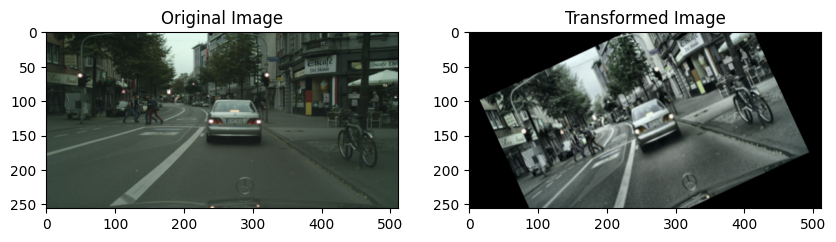

In [169]:
# Display the original and transformed images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_image)
ax[0].set_title("Original Image")
ax[1].imshow(transformed["image"])
ax[1].set_title("Transformed Image")
plt.show()

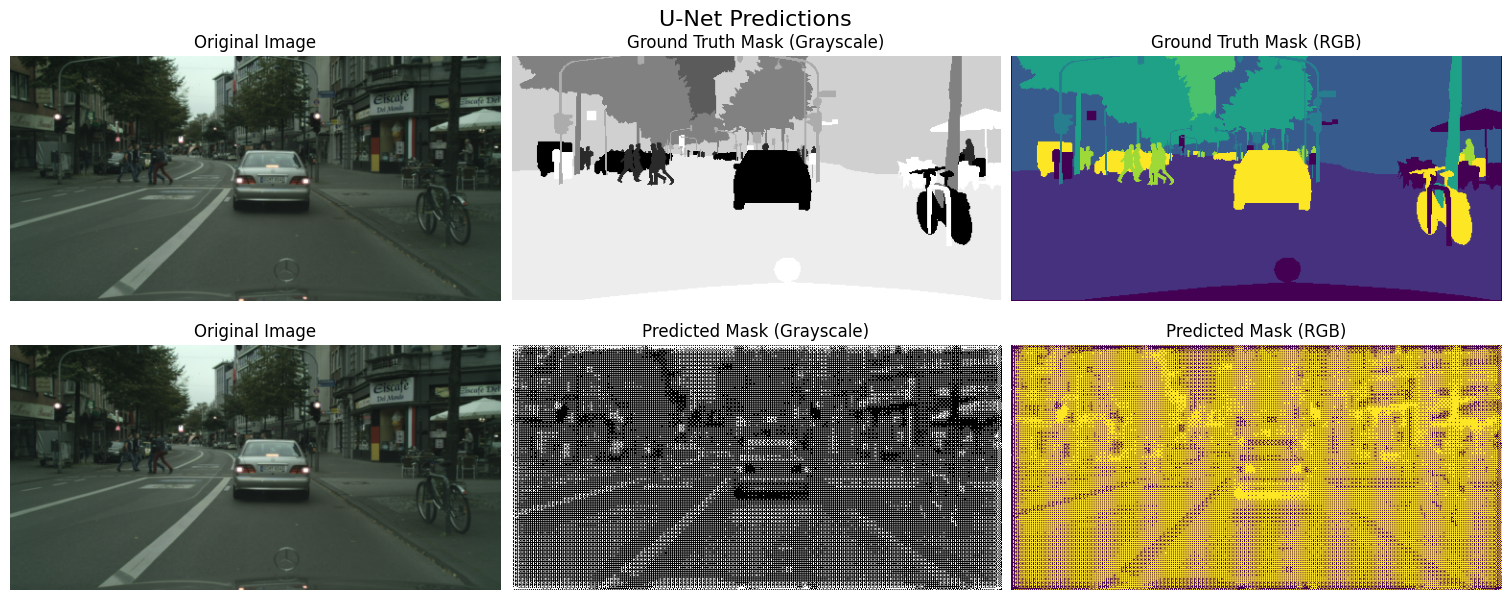

In [131]:
# Figure initialization
fig = plt.figure(layout="constrained", figsize=(15, 6))
fig.suptitle("U-Net Predictions", fontsize=16)
# Subfigures initialization
subfigs = fig.subfigures(2, 1, wspace=0.07)
axsTop = subfigs[0].subplots(1, 3, sharey=True, sharex=True)
axsBottom = subfigs[1].subplots(1, 3, sharey=True, sharex=True)
for i, ax in enumerate(axsTop):
    if i == 0:
        ax.imshow(test_image)
        ax.set_title("Original Image")
    elif i == 1:
        ax.imshow(test_mask, cmap="Greys")
        ax.set_title("Ground Truth Mask (Grayscale)")
    else:
        ax.imshow(test_mask)
        ax.set_title("Ground Truth Mask (RGB)")
    ax.axis("off")
for i, ax in enumerate(axsBottom):
    if i == 0:
        ax.imshow(test_image)
        ax.set_title("Original Image")
    elif i == 1:
        ax.imshow(preds_mask, cmap="Greys")
        ax.set_title("Predicted Mask (Grayscale)")
    else:
        ax.imshow(preds_mask)
        ax.set_title("Predicted Mask (RGB)")
    ax.axis("off")
plt.show()

In [133]:
# Pick a color palette for RGB labels with 7 colors (void is ignored)
sns.color_palette("tab10", 7)


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)]

In [132]:
# Assign the palette with 7 colors
palette = sns.color_palette("tab10", 7)
# Create a list of tuples in 255 RGB values
colors_list = [tuple(rgb) for rgb in (np.array(palette) * 255).astype(int).tolist()]
# Add the color for void
colors_list.insert(0, (0, 0, 0))
# Then create a mapping dict
category2rgb = {label: color for label, color in zip(range(8), colors_list)}
# Print the dict
print(category2rgb)

{0: (0, 0, 0), 1: (31, 119, 180), 2: (255, 127, 14), 3: (44, 160, 44), 4: (214, 39, 40), 5: (148, 103, 189), 6: (140, 86, 75), 7: (227, 119, 194)}
